# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [1]:
import glob
import os

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [3]:
# Search for all functional connectivity files and read them
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivity:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivity: 722
Number of features (connections): 34716


## Get Labels

In [4]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
# display(wisc_labels)

In [46]:
subject_ids = wisc_labels.index
measure_text = "WISC_Vocab_Scaled"
measure_col = f'assessment WISC,{measure_text}'
# measure_text = "Age"
# measure_col = 'assessment Basic_Demos,Age'

fc_matrices = []
measures = []

for subject_id in subject_ids:
    if subject_id not in fcs:
        continue
    
    fc_matrices.append(fcs[subject_id])
    measures.append(wisc_labels.at[subject_id, measure_col])
    
print("Num subjects with measures:", len(measures))

Num subjects with measures: 577


In [47]:
X = np.array(fc_matrices)
y = np.array(measures)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


## Train PLS Regression

### Determine optimal number of components

In [31]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

kf = KFold(n_splits=10)

In [32]:
num_component = 4
train_scores = []
test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)
    X_pls, y_pls = pls.transform(X, y)
    
    train_scores.append(pls.score(X_train, y_train))
    test_scores.append(pls.score(X_test, y_test))

print("Avg train score:", np.mean(train_scores))
print("Avg test score:", np.mean(test_scores))

Avg train score: 0.7185016213010156
Avg test score: 0.39996835530854796


### Use PLS to predict scores

0 0 0.12146795491666507
1 0 0.08689790265721986
2 0 -0.0035322630609693206
0 1 0.02204202376168618
1 1 -0.03898319324194177
2 1 0.08741871159457648
0 2 0.03766988634952262
1 2 0.03231897814980578
2 2 0.09670686656780136
Train r^2: 0.6601076438810014
Test r^2: 0.04074975716492956


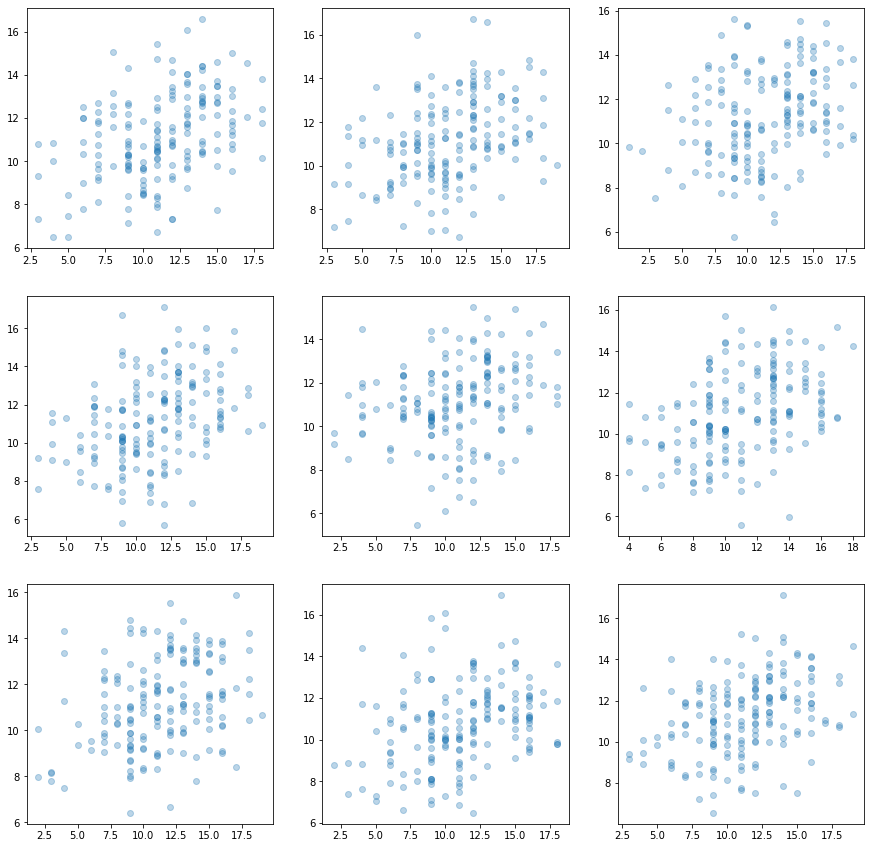

In [53]:
train_scores = []
test_scores = []
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
x_fig, y_fig = 0, 0

for i in range(0, 90):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3)
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)

    y_train_pred = pls.predict(X_train)
    y_test_pred = pls.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))
    if (i % 10 == 0):
        axs[y_fig, x_fig].scatter(y_test, y_test_pred, alpha=0.3)
        print(x_fig, y_fig, test_scores[-1])
        x_fig += 1
        if (x_fig % 3 == 0):
            x_fig = 0
            y_fig += 1

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)
plt.show()

In [42]:
train_scores = []
test_scores = []

for i in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3)
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)

    y_train_pred = pls.predict(X_train)
    y_test_pred = pls.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))
    if (i % 400 == 0):
        print("Iteration:", i)

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)

Iteration: 0
Train r^2: 0.6694108605334269
Test r^2: -0.21272336167031017


In [35]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_reg_train = LinearRegression().fit(y_train, y_train_pred)
y_train_pred_lin_reg = lin_reg_train.predict(y_train)

lin_reg_test = LinearRegression().fit(y_test, y_test_pred)
y_test_pred_lin_reg = lin_reg_test.predict(y_test)

lin_reg_train_score = lin_reg_train.score(y_train, y_train_pred)
lin_reg_test_score = lin_reg_test.score(y_test, y_test_pred)
print("Train r^2:", lin_reg_train_score)
print("Test r^2:", lin_reg_test_score)

Train r^2: 0.7375329344836576
Test r^2: 0.39402610638250146


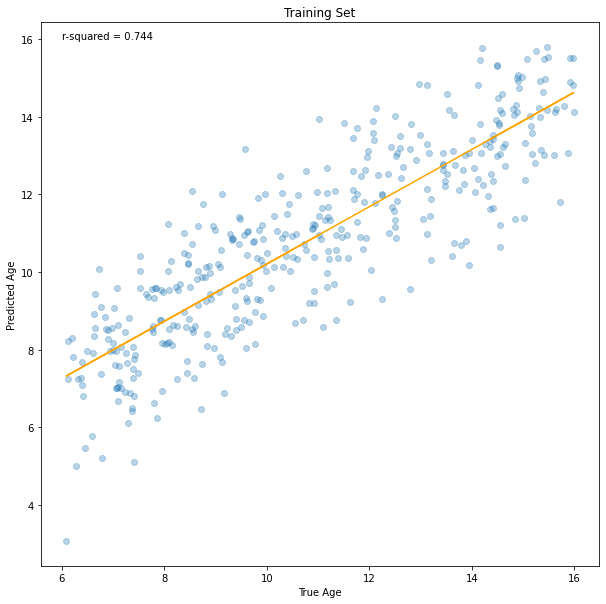

In [38]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot(y_train, y_train_pred_lin_reg, color='orange')
plt.title("Training Set")
plt.xlabel(f'True {measure_text}')
plt.ylabel(f'Predicted {measure_text}')
plt.annotate(f"r-squared = {avg_train_score:.3f}", (6, 16))
plt.show()

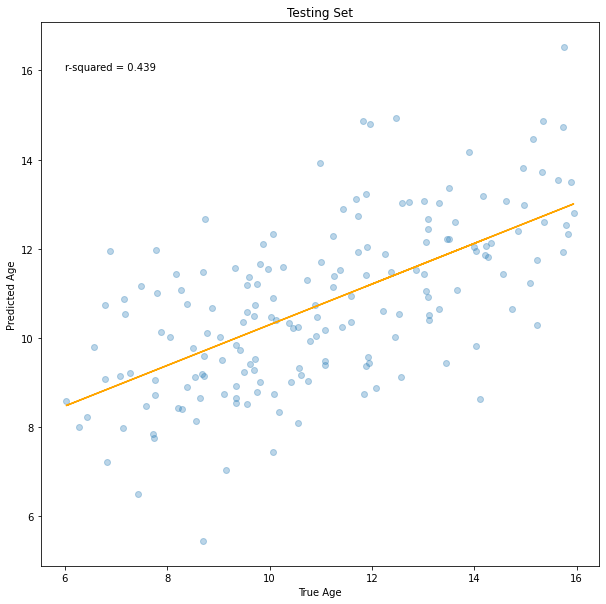

In [39]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot(y_test, y_test_pred_lin_reg, color='orange')
plt.title("Testing Set")
plt.xlabel(f'True {measure_text}')
plt.ylabel(f'Predicted {measure_text}')
plt.annotate(f"r-squared = {avg_test_score:.3f}", (6, 16))
plt.show()

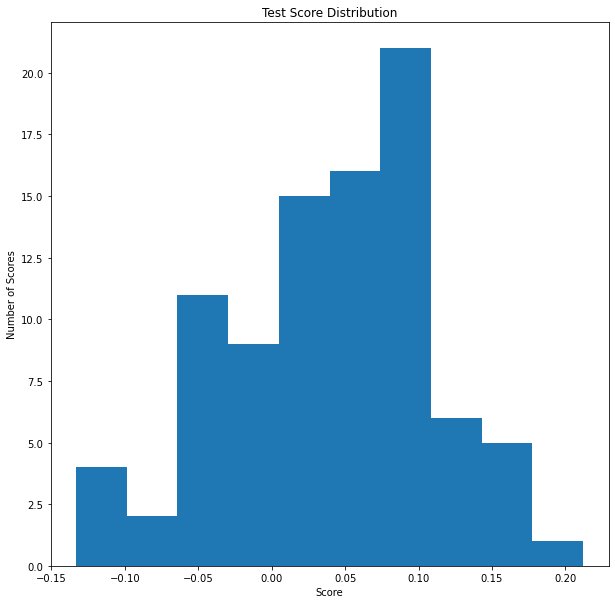

In [55]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=test_scores)
plt.title("Test Score Distribution")
plt.xlabel('Score')
plt.ylabel('Number of Scores')
plt.show()